In [1]:
pip install arch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 903.7/903.7 kB 14.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install pyGRNN

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
from keras.layers import Input, Dense, LSTM,Conv1D,Dropout,Bidirectional,Multiply
from keras.models import Model
import tensorflow as tf
from arch import arch_model
import sys
# from attention_utils import get_activations
# from keras.layers import merge
from keras.layers.core import *
from keras.layers import LSTM
from keras.layers import SimpleRNN
from keras.models import *
import os
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import math
import warnings
warnings.filterwarnings("ignore")
# from common.utils import load_data, mape
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import math
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from pyGRNN import GRNN
from sklearn.model_selection import  GridSearchCV
from sklearn.metrics import mean_squared_error as MSE

# **Part1:Model construction**

In this part, we construct some NN models

### LSTM

In [4]:
#Machine Learning model construction
def ML_model_LSTM(step,dropout):
    inputs = Input(shape=(step, INPUT_DIMS))

#     x = Conv1D(filters = 64, kernel_size = 1, activation = 'relu')(inputs)  #, padding = 'same'
#     x = Dropout(0.1)(x)

#     lstm_out = Bidirectional(LSTM(lstm_units, activation='relu'), name='bilstm')(x)
    lstm_out = LSTM(lstm_units, return_sequences=True)(inputs)
    lstm_out = LSTM(lstm_units, return_sequences=True)(lstm_out)
    lstm_out = Dropout(dropout)(lstm_out)
#     lstm_out = Bidirectional(LSTM(lstm_units, return_sequences=True))(lstm_out)
#     lstm_out = Bidirectional(LSTM(lstm_units, return_sequences=True))(lstm_out)
#     lstm_out = Bidirectional(LSTM(lstm_units, return_sequences=True))(lstm_out)
#     attention_mul = attention_3d_block(lstm_out)
#     attention_mul = attention_3d_block(attention_mul)
    attention_mul = Flatten()(lstm_out)

    output = Dense(1, activation='sigmoid')(attention_mul)
    model = Model(inputs=[inputs], outputs=output)
    return model

### RNN

In [5]:
def ML_model_RNN(step,dropout):
    inputs = Input(shape=(step, INPUT_DIMS))

#     x = Conv1D(filters = 64, kernel_size = 1, activation = 'relu')(inputs)  #, padding = 'same'
#     x = Dropout(0.1)(x)

#     lstm_out = Bidirectional(LSTM(lstm_units, activation='relu'), name='bilstm')(x)
    RNN_out = SimpleRNN(lstm_units*2, return_sequences = True)(inputs)
    RNN_out = SimpleRNN(lstm_units*2, return_sequences=True)(RNN_out)
#     lstm_out = SimpleRNN(lstm_units*2, return_sequences=True)(lstm_out)
#     lstm_out = Bidirectional(LSTM(lstm_units, return_sequences=True))(lstm_out)
#     attention_mul = attention_3d_block(lstm_out)
#     attention_mul = attention_3d_block(attention_mul)
    RNN_out = Dropout(dropout)(RNN_out)
    attention_mul = Flatten()(RNN_out)

    output = Dense(1, activation='sigmoid')(attention_mul)
    model = Model(inputs=[inputs], outputs=output)
    return model

### BiLSTM

In [6]:
def ML_model_BiLSTM(step,dropout):
    inputs = Input(shape=(step, INPUT_DIMS))

#     x = Conv1D(filters = 64, kernel_size = 1, activation = 'relu')(inputs)  #, padding = 'same'
#     x = Dropout(0.1)(x)

#     lstm_out = Bidirectional(LSTM(lstm_units, activation='relu'), name='bilstm')(x)
    lstm_out = Bidirectional(LSTM(lstm_units, return_sequences=True))(inputs)
#     lstm_out = Bidirectional(LSTM(lstm_units, return_sequences=True))(lstm_out)
    lstm_out = Bidirectional(LSTM(lstm_units, return_sequences=True))(lstm_out)
    lstm_out = Dropout(dropout)(lstm_out)
#     lstm_out = Bidirectional(LSTM(lstm_units, return_sequences=True))(lstm_out)
#     attention_mul = attention_3d_block(lstm_out)
#     attention_mul = attention_3d_block(attention_mul)
    attention_mul = Flatten()(lstm_out)

    output = Dense(1, activation='sigmoid')(attention_mul)
    model = Model(inputs=[inputs], outputs=output)
    return model

### SVR

In [7]:
def ML_model_SVR():
    model = SVR(kernel='rbf',gamma=0.5, C=10, epsilon = 0.05)
    return model

### Transformer

In [8]:
#define some function that Transformer needs
class MultiHeadSelfAttention(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}")
        self.projection_dim = embed_dim // num_heads
        self.query_dense = tf.keras.layers.Dense(embed_dim)
        self.key_dense = tf.keras.layers.Dense(embed_dim)
        self.value_dense = tf.keras.layers.Dense(embed_dim)
        self.combine_heads = tf.keras.layers.Dense(embed_dim)
    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights
    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)  # (batch_size, seq_len, embed_dim)
        key = self.key_dense(inputs)  # (batch_size, seq_len, embed_dim)
        value = self.value_dense(inputs)  # (batch_size, seq_len, embed_dim)
        query = self.separate_heads(query, batch_size)  # (batch_size, num_heads, seq_len, projection_dim)
        key = self.separate_heads(key, batch_size)  # (batch_size, num_heads, seq_len, projection_dim)
        value = self.separate_heads(value, batch_size)  # (batch_size, num_heads, seq_len, projection_dim)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len, num_heads, projection_dim)
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim))  # (batch_size, seq_len, embed_dim)
        output = self.combine_heads(concat_attention)  # (batch_size, seq_len, embed_dim)
        return output

class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = tf.keras.Sequential([tf.keras.layers.Dense(ff_dim, activation="relu"), tf.keras.layers.Dense(embed_dim),])
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


In [9]:
#Traditional emmbeding position for NLP in transformers
def position_encoding_init(n_position, d_pos_vec):
    # keep dim 0 for padding token position encoding zero vector
    position_enc = np.array([
        [pos / np.power(10000, 2*i/d_pos_vec) for i in range(d_pos_vec)]
        if pos != 0 else np.zeros(d_pos_vec) for pos in range(n_position)])

    position_enc[1:, 0::2] = np.sin(position_enc[1:, 0::2]) # dim 2i
    position_enc[1:, 1::2] = np.cos(position_enc[1:, 1::2]) # dim 2i+1
    return position_enc
#Encoding only for the temporal component of the variables.For non-NLP problems.
def position_encoding_init(n_position, d_pos_vec):
    position_enc = np.array([
        [math.pi*(pos/(n_position-1)) for i in range(d_pos_vec)]
        if pos != 0 else np.zeros(d_pos_vec) for pos in range(n_position)])
    return np.cos(position_enc)

In [10]:
#Transformer model is generated
def ML_model_Transformer (Shape1, Shape2, HeadsAttention,Dropout, LearningRate):
    #Model struture is defined
    Input = tf.keras.Input(shape=(Shape1,Shape2), name="Input")
    transformer_block_1 = TransformerBlock(embed_dim=Shape2, num_heads=HeadsAttention, ff_dim=8, rate=Dropout)
    X = transformer_block_1(Input)
#     transformer_block_2 = TransformerBlock(embed_dim=Shape2, num_heads=HeadsAttention, ff_dim=8, rate=Dropout)
#     X = transformer_block_2(X)
    X = tf.keras.layers.GlobalAveragePooling1D()(X)
    X = tf.keras.layers.Dropout(Dropout)(X)
    X = tf.keras.layers.Dense(8, activation=tf.nn.sigmoid)(X)
    X = tf.keras.layers.Dropout(Dropout)(X)
    Output = tf.keras.layers.Dense(1, activation=tf.nn.sigmoid, name="Output")(X)
    model = tf.keras.Model(inputs=Input, outputs=Output)
    #Optimizer is defined
    Opt = tf.keras.optimizers.Adam(learning_rate=LearningRate, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,name='Adam')
    #Model is compiled
    model.compile(optimizer=Opt, loss='mean_squared_error', metrics=['mean_squared_error'])
    return model

### ANN

In [11]:
def ML_model_ANN (Input_Dimension_NN, DropoutRate, LearningRate):
    #Model struture is defined
    Inputs = tf.keras.Input(shape=(Input_Dimension_NN,), name="Input")
    X = tf.keras.layers.Dense(16, activation=tf.nn.sigmoid, name="Dense1") (Inputs)
    X = tf.keras.layers.Dropout(DropoutRate) (X)
    X = tf.keras.layers.Dense(8, activation=tf.nn.sigmoid, name="Dense2") (X)
    X = tf.keras.layers.Dropout(DropoutRate) (X)
#     X = tf.keras.layers.Dense(4, activation=tf.nn.sigmoid, name="Dense3") (X)
#     X = tf.keras.layers.Dropout(DropoutRate) (X)
    Output = tf.keras.layers.Dense(1, activation=tf.nn.sigmoid, name="Output") (X)
    #Output = tf.keras.layers.Dropout(DropoutRate) (X)
    model = tf.keras.Model(inputs=Inputs, outputs=Output)
    #Optimizer is defined
    Opt = tf.keras.optimizers.Adam(learning_rate=LearningRate, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,name='Adam')
    #Model is compiled
    model.compile(optimizer=Opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model,Inputs


### CNN

In [12]:
def ML_model_CNN(step,dropout):
    model = Sequential()
    #50个filter卷积核 学习到更多的特征，same保证维度不变
    model.add(Conv1D(50,4,padding='same',activation='relu',input_shape=(step,index_number))) 
    model.add(MaxPooling1D(2))#每两个取一个大的   数据会减少一半
    model.add(Flatten())#把二维数据变成一维的

    model.add(Dense(20))#20个神经元的全连接层
    model.add(Dropout(dropout))#防止过拟合 20%权重冻结
    model.add(Activation('relu'))
    model.add(Dense(1))#输出层 是一个一维的全连接神经网络
    model.add(Activation('sigmoid'))

    #model.compile(loss='mse',optimizer=SGD(lr=0.2), metrics['accuracy'])
    model.compile(loss='mse', optimizer=SGD(lr=0.2))
    model.summary()
    return model

### RBFNN

In [13]:
from keras import backend as K
# from keras.engine.topology import Layer 注释掉，改为下一行即可。
from keras.layers import Layer
from keras.initializers import RandomUniform, Initializer, Constant

#define some function that RBFNN needs
class InitCentersRandom(Initializer):
    """ Initializer for initialization of centers of RBF network
        as random samples from the given data set.
    # Arguments
        X: matrix, dataset to choose the centers from (random rows
          are taken as centers)
    """

    def __init__(self, X):
        self.X = X

    def __call__(self, shape, dtype=None):
        assert shape[1] == self.X.shape[1]
        idx = np.random.randint(self.X.shape[0], size=shape[0])
        return self.X[idx, :]


class RBFLayer(Layer):
    """ Layer of Gaussian RBF units.
    # Example
    ```python
        model = Sequential()
        model.add(RBFLayer(10,
                           initializer=InitCentersRandom(X),
                           betas=1.0,
                           input_shape=(1,)))
        model.add(Dense(1))
    ```
    # Arguments
        output_dim: number of hidden units (i.e. number of outputs of the
                    layer)
        initializer: instance of initiliazer to initialize centers
        betas: float, initial value for betas
    """

    def __init__(self, output_dim, initializer=None, betas=1.0, **kwargs):
        self.output_dim = output_dim
        self.init_betas = betas
        if not initializer:
            self.initializer = RandomUniform(0.0, 1.0)
        else:
            self.initializer = initializer
        super(RBFLayer, self).__init__(**kwargs)

    def build(self, input_shape):

        self.centers = self.add_weight(name='centers',
                                       shape=(self.output_dim, input_shape[1]),
                                       initializer=self.initializer,
                                       trainable=True)
        self.betas = self.add_weight(name='betas',
                                     shape=(self.output_dim,),
                                     initializer=Constant(
                                         value=self.init_betas),
                                     # initializer='ones',
                                     trainable=True)

        super(RBFLayer, self).build(input_shape)

    def call(self, x):

        C = K.expand_dims(self.centers)
        H = K.transpose(C-K.transpose(x))
        return K.exp(-self.betas * K.sum(H**2, axis=1))

        # C = self.centers[np.newaxis, :, :]
        # X = x[:, np.newaxis, :]

        # diffnorm = K.sum((C-X)**2, axis=-1)
        # ret = K.exp( - self.betas * diffnorm)
        # return ret

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

    def get_config(self):
        # have to define get_config to be able to use model_from_json
        config = {
            'output_dim': self.output_dim
        }
        base_config = super(RBFLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

from keras.initializers import Initializer
from sklearn.cluster import KMeans


class InitCentersKMeans(Initializer):
    """ Initializer for initialization of centers of RBF network
        by clustering the given data set.
    # Arguments
        X: matrix, dataset
    """

    def __init__(self, X, max_iter=100):
        self.X = X
        self.max_iter = max_iter

    def __call__(self, shape, dtype=None):
        assert shape[1] == self.X.shape[1]

        n_centers = shape[0]
        km = KMeans(n_clusters=n_centers, max_iter=self.max_iter, verbose=0)
        km.fit(self.X)
        return km.cluster_centers_

# Commented out IPython magic to ensure Python compatibility.
# import numpy as np, pandas as pd
# from keras.models import Sequential 
# from keras.layers.core import Dense
from keras.layers import Activation
from keras.optimizers import RMSprop
# import matplotlib.pyplot as plt

In [14]:
def ML_model_RBFNN(X_train1,dropout): 
    RBFNN_model = Sequential()
    # RBFNN_model.add(RBFLayer(1,initializer=InitCentersRandom(X_train),betas=0.5,input_shape=(X_train.shape[1],)))
            #RBFNN_model.add(Dense(5))
            #RBFNN_model.add(Dropout(0.3))
    rbflayer = RBFLayer(10, initializer = InitCentersKMeans(X_train1),betas = 3, input_shape = (X_train1.shape[1],))
    RBFNN_model.add(rbflayer)
            # This is the last output layer
    RBFNN_model.add(Dropout(dropout))
    RBFNN_model.add(Dense(1,activation='sigmoid'))
            # Our main purpose is clustering that's why we choosed the parameters appropriately
    RBFNN_model.compile(loss = 'mean_squared_error',optimizer = 'adam',metrics = ['accuracy'])
    return RBFNN_model
# prediction_RBFF_noroll = RBFNN_model.predict(X_test)

### GRNN

In [15]:
GRNN = GRNN()
def ML_model_GRNN():
    params_GRNN = {'kernel':["RBF"],
                     'sigma' : list(np.arange(0.1, 4, 0.01)),
                     'calibration' : ['None']
                      }

        # GridSearchCV tries to find best parameters for above
    grid_GRNN = GridSearchCV(estimator=GRNN,param_grid=params_GRNN,scoring='neg_mean_squared_error',cv=5,verbose = 0)
    
    return grid_GRNN

# **Part2: Training set creation function**

In [16]:
# function used to create training set
def training_set_creation(dataset,step,length):
    X_train = []
    y_train = []
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(dataset)
    for i in range(step, length):
        X_train.append(data[i-step:i,-2:])
        y_train.append(data[i,-1])
    X_train, y_train = np.array(X_train), np.array(y_train)
    return X_train,y_train

In [17]:
#Since there are some difference for SVR model and other normal models of RNN model, 
#the training set creation function are different
def training_set_creation_SVR(dataset,step,length):
    X_train = []
    y_train = []
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(dataset)
    for i in range(step, length):
        X_train.append(data[i-step:i,-1])
        y_train.append(data[i,-1])
    X_train, y_train = np.array(X_train), np.array(y_train)
    return X_train,y_train

In [18]:
#For Transformer training set creation, we should add positional encoding
def training_set_creation_TF(dataset,step,length):
    X_train = []
    y_train = []
    X_final = []
    Pos_Encoding = position_encoding_init(step, dataset.shape[1]) #Positional Encoding
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(dataset)
    for i in range(step, length):
#         scaler = MinMaxScaler(feature_range=(0, 1))
        X_train.append(data_scaled[i-step:i,-1:]+Pos_Encoding)
        y_train.append(data_scaled[i,-2])
    #训练集的最后一个step
    scaler = MinMaxScaler(feature_range=(0, 1))
    X_final.append(data_scaled[-step:,:]+Pos_Encoding)
    X_train, y_train, X_final = np.array(X_train), np.array(y_train), np.array(X_final)
    return X_train,y_train,X_final

# **Part3: Prediction function**

In [19]:
# used to predict result one by one
def prediction(dataset,step,length,index_number,regressor):
    prediction_test = []
    for i in range(step, length):
        rolling_scaler = MinMaxScaler(feature_range=(0, 1))

        result = regressor.predict(rolling_scaler.fit_transform(dataset[i-step:i,:]).reshape(1,step,index_number))
        zero5_test = np.zeros(index_number-1).reshape(1,index_number-1)
        result = rolling_scaler.inverse_transform(np.append(zero5_test,result,axis = 1))[0,-1]
#         result = rolling_scaler.inverse_transform(result)
        prediction_test.append(result)

    return prediction_test

In [20]:
def prediction_SVR(dataset,step,length,regressor):

    prediction_test = []
    for i in range(step, length):
        rolling_scaler = MinMaxScaler(feature_range=(0, 1))

        result = regressor.predict(rolling_scaler.fit_transform(dataset[i-step:i].reshape(-1,1)).reshape(1,step))

        result = rolling_scaler.inverse_transform(result.reshape(-1,1))[0,0]
        prediction_test.append(result)

    return prediction_test

In [21]:
def prediction_TF(dataset,step,length,index_number,regressor):
#     X_test = []
    prediction_test = []
    Pos_Encoding=position_encoding_init(step, dataset.shape[1]) 
    for i in range(step, length):
        rolling_scaler = MinMaxScaler(feature_range=(0, 1))

        result = regressor.predict((rolling_scaler.fit_transform(dataset[i-step:i,:])+Pos_Encoding).reshape(1,step,index_number))
        zero5_test = np.zeros(index_number-1).reshape(1,index_number-1)
        result = rolling_scaler.inverse_transform(np.append(zero5_test,result,axis = 1))[0,-1]
#         result = rolling_scaler.inverse_transform(result)
        prediction_test.append(result)


    return prediction_test

In [22]:
def prediction_CNN(dataset,step,length,index_number,regressor):
#     X_test = []
    prediction_test = []
    for i in range(step, length):
        rolling_scaler = MinMaxScaler(feature_range=(0, 1))

        result = regressor.predict(rolling_scaler.fit_transform(dataset[i-step:i,:]).reshape(1,step,index_number))
        zero5_test = np.zeros(index_number-1).reshape(1,index_number-1)
        result = rolling_scaler.inverse_transform(np.append(zero5_test,result,axis = 1))[0,-1]
#         result = rolling_scaler.inverse_transform(result)
        prediction_test.append(result)

    return prediction_test

In [23]:
def prediction_RBF(dataset,step,length,regressor):
    prediction_test = []
    for i in range(step, length):
        rolling_scaler = MinMaxScaler(feature_range=(0, 1))
        result = regressor.predict(rolling_scaler.fit_transform(dataset[i-step:i].reshape(-1,1)).reshape(1,step))
        result = rolling_scaler.inverse_transform(result.reshape(-1,1))[0,0]
        prediction_test.append(result)
    return prediction_test

In [24]:
def prediction_GRNN(dataset,step,length,regressor):
    prediction_test = []
    for i in range(step, length):
        rolling_scaler = MinMaxScaler(feature_range=(0, 1))
        result = regressor.predict(rolling_scaler.fit_transform(dataset[i-step:i].reshape(-1,1)).reshape(1,step))
        result = rolling_scaler.inverse_transform(result.reshape(-1,1))[0,0]
        prediction_test.append(result)
    return prediction_test

# **Part4: Data preprocessing**

In this part, firstly, we define some functions to generate some technical indicators for better training NN models. Secondly, **True volatility(Historical volatility)** is computed according to the value of windows. Thirdly, **GARCH(1,1)** model is implemented to get **GARCH volatility** part of model. 

In [25]:
''' Technical Indicators '''

#Calculation of moving average
def ma(df, n):
    return pd.Series(df['Close'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))

# exponentially weighted moving average 
def ema(df, n):
    return pd.Series(df['Close'].ewm(span=n,min_periods=n).mean(), name='EMA_' + str(n))

#Calculation of price momentum
def mom(df, n):     
    return pd.Series(df.diff(n), name='Momentum_' + str(n))  

# rate of change
def roc(df, n):
    M = df.diff(n - 1) ; N = df.shift(n - 1)  
    return pd.Series(((M / N) * 100), name = 'ROC_' + str(n)) 

# relative strength index
def rsi(df, period):
    delta = df.diff().dropna()
    u = delta * 0; d = u.copy()
    u[delta > 0] = delta[delta > 0]; d[delta < 0] = -delta[delta < 0]
    u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
    u = u.drop(u.index[:(period-1)])
    d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
    d = d.drop(d.index[:(period-1)])
    rs = u.ewm(com=period-1, adjust=False).mean() / d.ewm(com=period-1, adjust=False).mean()
    return 100 - 100 / (1 + rs)

# stochastic oscillators slow & fast
def sto(close, low, high, n,id): 
    stok = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
    if(id is 0):
        return stok
    else:
        return stok.rolling(3).mean()

In [26]:
def tech_indi(ldf,tr_id=True):

    ''' Moving Average '''
    ldf['MA10'] = ma(ldf,10)
    ldf['MA30'] = ma(ldf, 30)
    ldf['MA200'] = ma(ldf, 200)
    lst_MA = ['MA10','MA30','MA200']

    ''' Exponentially Weighted Moving Average '''
    ldf['EMA10'] = ema(ldf, 10)
    ldf['EMA30'] = ema(ldf, 30)
    ldf['EMA200'] = ema(ldf, 200)
    lst_EMA = ['EMA10','EMA30','EMA200']

    ''' Momentum '''
#     ldf['MOM10'] = mom(ldf['Close'], 10)
    ldf['MOM30'] = mom(ldf['Close'], 30)
    lst_MOM = ['MOM30']

    ''' Relative Strength Index '''
#     ldf['RSI10'] = rsi(ldf['Close'], 10)
#     ldf['RSI30'] = rsi(ldf['Close'], 30)
    ldf['RSI200'] = rsi(ldf['Close'], 200)
    lst_RSI = ['RSI10','RSI30','RSI200']

In [27]:
def preprocess(df,windows):
    if df.iloc[0,0] == '2021/12/31':
        df = df[::-1].reset_index().drop(columns = ['index'])
    tech_indi(df)
    df = df.set_index('Date')
    df['log_return'] = np.log(df['Close']).diff()
    df = df.dropna()
#     df.index = df.to_datetime(df.index)
    df['gap'] = df['High'] - df['Low']
    df = df.drop(['Open','Adj Close','High','Low'],axis=1)
    # btc.insert(12,'Annualized Volatility',btc_vol)
    df['Truevol'] = df['log_return'].rolling(window = windows).std()
    df = df.dropna()
    
    # Split the train and test set by 70-30 rule
    Train_set = df[['log_return']]
    n = len(Train_set)
    n_train = int(n * 0.7)
    n_test = n - n_train
#     split_date = X_test.index[0]
    print('No. train:', n_train)
    print('No. test:', n_test)
#     print('Split date:', split_date)
    
    Train_set = Train_set*100
    am = arch_model(Train_set[:n_train], vol='Garch', p=1, o=0, q=1, dist='StudentsT')
    res = am.fit(disp='off')
    display(res.summary())
    
    index = Train_set.index
    forecasts = []

    for i in range(n_test):
        sys.stdout.write(".")
        sys.stdout.flush()
        train = Train_set[:-(n_test - i)]
        model = arch_model(train, p=1, q=1)
        model_fit = model.fit(disp='off')
        pred = model_fit.forecast(horizon=1)
        forecasts.append(np.sqrt(pred.variance.values[-1, :][0])/100)
        
    df['garch_vol'] = (np.sqrt(res.params['omega'] + res.params['alpha[1]'] * res.resid**2 + 
                                   res.conditional_volatility**2 * res.params['beta[1]']))/100
    df.iloc[n_train:,-1] = forecasts
    True_vol = df['Truevol'].values
    df = df.drop(['Truevol'],axis=1)
    df.insert(13,'Truevol',True_vol)
    df = df.dropna()
    return df

# **Part5: Model training and prediction**

In this part, many normal machine learning models are constructed to fit the training data of the volatility and make prediction of the value. It's worthy to notice that training set contains **500 days data** and testing set contains **200 days data**. Besides, some figures are plotted to vividly represent the performance of different model. 

In [28]:
step = 30
index_number = 2
INPUT_DIMS = 2
TIME_STEPS = step
lstm_units = 64
callbacks = [tf.keras.callbacks.EarlyStopping(patience=50, restore_best_weights=True)]
datalist = ['50','BTC-USD','BZF','CSI300','DX-Y.NYB','FTSE','GSPC','HSI','LTC-USD','N225','QQQ']

*The following part will take around 10 mins*

In [29]:
def training(stock,step,train_length,dropout):
    ## import data
    btc = preprocess(pd.read_csv('/kaggle/input/benchmark/'+stock+'.csv'),30)
    data_TF = btc.copy()
    data_TF = data_TF.drop(columns = ['Volume','MA200'])
    data_CNN = btc.copy()
    Truevol=btc.iloc[:,-1]
#     data_CNN = data_CNN.drop(columns = ['Volume'])
    ## trainig and testing set creation
    train1 = int(btc.shape[0] * 0.7)
    X_train, y_train = training_set_creation(btc.iloc[train1-train_length:train1,:].values,step,train_length)
    test_set = btc.iloc[train1-step:train1+200,-2:].values

    X_train1,y_train1 = training_set_creation_SVR(btc.iloc[train1-train_length:train1,:].values,step,train_length)
    test1 = btc.shape[0] - train1 + step
    test_set1 = btc.iloc[train1-step:train1+200,-1].values
   
    training_set_TF_noroll = data_TF.iloc[train1-train_length:train1,-2:].values
    X_train2,y_train2,X_final = training_set_creation_TF(training_set_TF_noroll,step,training_set_TF_noroll.shape[0])
    test_set_TF_noroll = data_TF.iloc[train1-step:train1+200,-2:].values

    training_set_CNN_noroll = data_CNN.iloc[train1-train_length:train1,:].values
    X_train3,y_train3= training_set_creation(training_set_CNN_noroll,step,training_set_CNN_noroll.shape[0])
    test_set_CNN_noroll = data_CNN.iloc[train1-step:train1+200,-2:].values
    
    
    ###lstm
    LSTM_model = ML_model_LSTM(step,dropout)
    LSTM_model.compile(optimizer='adam', loss='mse')
    LSTM_model.fit(X_train, y_train, epochs=5000, batch_size=64, validation_split=0.1,verbose = 0,callbacks = callbacks)
    prediction_LSTM = prediction(test_set,step,test_set.shape[0],index_number,LSTM_model)

    ###RNN
    RNN_model = ML_model_RNN(step,dropout)
    RNN_model.compile(optimizer='adam', loss='mse')
    RNN_model.fit(X_train, y_train, epochs=5000, batch_size=64, verbose = 0,validation_split=0.1,callbacks = callbacks)
    prediction_RNN = prediction(test_set,step,test_set.shape[0],index_number,RNN_model)

    ### BiLSTM

    BiLSTM_model = ML_model_BiLSTM(step,dropout)
    BiLSTM_model.compile(optimizer='adam', loss='mse')
    BiLSTM_model.fit(X_train, y_train, epochs=5000, batch_size=64, verbose = 0,validation_split=0.1,callbacks = callbacks)
    prediction_BiLSTM = prediction(test_set,step,test_set.shape[0],index_number,BiLSTM_model)

    ###SVR
    SVR_model = ML_model_SVR()
    SVR_model.fit(X_train1, y_train1)
    prediction__SVR = prediction_SVR(test_set1,step,test_set1.shape[0],SVR_model)

    ### Transformer
    TF_model = ML_model_Transformer(X_train2.shape[1], X_train2.shape[2], HeadsAttention=1, Dropout=dropout, LearningRate=0.01)
    TF_model.fit(X_train2, y_train2, epochs=5000, verbose=0, batch_size=64,callbacks = callbacks)
    prediction__TF = prediction_TF(test_set_TF_noroll,step,test_set_TF_noroll.shape[0],2,TF_model)

    ###ANN
    ANN_model,inputs = ML_model_ANN(X_train.shape[1],DropoutRate=dropout, LearningRate=0.01)
    ANN_model.fit(X_train1,y_train1,epochs = 5000,verbose = 0,batch_size = 64,callbacks = callbacks)
    prediction_ANN = prediction_SVR(test_set1,step,test_set1.shape[0],ANN_model)

    ###CNN
    CNN_model = ML_model_CNN(step,dropout)
    CNN_model.fit(X_train3,y_train3,epochs=5000,callbacks = callbacks,batch_size=64,verbose = 0)
    prediction__CNN = prediction_CNN(test_set_CNN_noroll,step,test_set_CNN_noroll.shape[0],index_number,CNN_model)

    ###RBFNN
    RBFNN_model = ML_model_RBFNN(X_train1,dropout)
    RBFNN_model.fit(X_train1, y_train1,epochs=5000,batch_size=64,callbacks = callbacks,verbose = 0)
    prediction__RBF = prediction_RBF(test_set1,step,test_set1.shape[0],RBFNN_model)

    ###GRNN
    GRNN_model = ML_model_GRNN()
    GRNN_model.fit(X_train1, y_train1)
    # From models created by GridSearchCV we get the best options we have
    best_model = GRNN_model.best_estimator_
    prediction__GRNN = prediction_GRNN(test_set1,step,test_set1.shape[0],best_model)
    return btc,Truevol,{'Transformer':prediction__TF,'SVR':prediction__SVR,'LSTM':prediction_LSTM,'BiLSTM':prediction_BiLSTM,'RNN':prediction_RNN,'ANN':prediction_ANN,'CNN':prediction__CNN,'RBFNN':prediction__RBF,'GRNN':prediction__GRNN}

### Here we use QQQ as the example

**Firstly, train and predict the vol**

In [30]:
name = '50'

In [31]:
def rmse(targets,predictions): 
    predictions = np.array(predictions)
    rmse = np.sqrt(((predictions - targets) ** 2).mean())
    rmse_percent = rmse*100
    return rmse_percent
def mape(targets,predictions):
    predictions = np.array(predictions)
    error = (np.abs(targets - predictions)/targets).mean()
    error_percent = error*100
    return error_percent
def trend_error(targets,predictions):
    targets = targets.reshape(-1,)
    predictions = np.array(predictions).reshape(-1,)
    targets_trend = pd.DataFrame(targets,columns = ['trend']).diff().dropna()
    targets_trend['trend'] = targets_trend.apply(lambda x: 1 if x[0]>=0 else 0, axis=1)
    predictions_trend = pd.DataFrame(predictions,columns = ['trend']).diff().dropna()
    predictions_trend['trend'] = predictions_trend.apply(lambda x: 1 if x[0]>=0 else 0, axis=1)
    error_table = (targets_trend == predictions_trend)
    error_table = error_table.apply(lambda x:1 if x[0] == True else 0,axis = 1)
    percent = (np.sum(error_table)/error_table.shape[0])*100
    return percent

In [32]:
STEP = [30]
DROPOUT = [0.1]
TRAIN = [500]
# STEP = [5]
# DROPOUT = [0]
# TRAIN = [300]
index_number = 2
INPUT_DIMS = 2
# TIME_STEPS = STEP
# lstm_units = 64
# callbacks = [tf.keras.callbacks.EarlyStopping(patience=50, restore_best_weights=True)]
# datalist = ['50','BTC-USD','BZF','CSI300','DX-Y.NYB','FTSE','GSPC','HSI','LTC-USD','N225','QQQ']

In [33]:
Train_Predresult = training(name,30,500,0.1)
btc = Train_Predresult[0]
Truevol = Train_Predresult[1]
train1 = int(btc.shape[0] * 0.7)
result_dic = Train_Predresult[2]
result_dic_key = result_dic.keys()

No. train: 1542
No. test: 661


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:                   log_return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -2405.26
Distribution:      Standardized Student's t   AIC:                           4820.52
Method:                  Maximum Likelihood   BIC:                           4847.23
                                              No. Observations:                 1542
Date:                      Tue, Aug 08 2023   Df Residuals:                     1541
Time:                              14:54:13   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0528  2.172e-02      2.431  1.504e-02 [1.024e-02,9.540e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0175  8.567e-03      2.040  4.138e-02 [6.831e-04,3.426e-02]
alpha[1]       0.0732  1.737e-02      4.212  2.533e-05   [3.911e-02,  0.107]
beta[1]        0.9268  1.781e-02     52.043      0.000     [  0.892,  0.962]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             3.5344      0.302     11.715  1.062e-31 [  2.943,  4.126]
========================================================================

Covariance estimator: robust
"""

1/1 [==============================] - 0s 27ms/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 30, 50)            450       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 15, 50)           0         
 )                                                               
                                                                 
 flatten_3 (Flatten)         (None, 750)               0         
                                                                 
 dense_10 (Dense)            (None, 20)                15020     
                                                                 
 dropout_9 (Dropout)         (None, 20)                0         
                                                                 
 activation (Activation)     (None, 20)                0         
  

In [34]:
result = {
'GARCH':[rmse(btc.iloc[train1:train1+200, -1].values,btc.iloc[train1:train1+200, -2].values),mape(btc.iloc[train1:train1+200, -1].values,btc.iloc[train1:train1+200, -2].values),trend_error(btc.iloc[train1:train1+200, -1].values,btc.iloc[train1:train1+200, -2].values)],
'Transformer':[rmse(btc.iloc[train1:train1+200, -1].values,result_dic['Transformer']),mape(btc.iloc[train1:train1+200, -1].values,result_dic['Transformer']),trend_error(Truevol[train1:train1+200].values,btc.iloc[train1:train1+200, -2].values+result_dic['Transformer'])],
'SVR':[rmse(btc.iloc[train1:train1+200, -1].values,result_dic['SVR']),mape(btc.iloc[train1:train1+200, -1].values,result_dic['SVR']),trend_error(Truevol[train1:train1+200].values,btc.iloc[train1:train1+200, -2].values+result_dic['SVR'])],
'LSTM':[rmse(btc.iloc[train1:train1+200, -1].values,result_dic['LSTM']),mape(btc.iloc[train1:train1+200, -1].values,result_dic['LSTM']),trend_error(Truevol[train1:train1+200].values,btc.iloc[train1:train1+200, -2].values+result_dic['LSTM'])],
'BiLSTM':[rmse(btc.iloc[train1:train1+200, -1].values,result_dic['BiLSTM']),mape(btc.iloc[train1:train1+200, -1].values,result_dic['BiLSTM']),trend_error(Truevol[train1:train1+200].values,btc.iloc[train1:train1+200, -2].values+result_dic['BiLSTM'])],
'RNN':[rmse(btc.iloc[train1:train1+200, -1].values,result_dic['RNN']),mape(btc.iloc[train1:train1+200, -1].values,result_dic['RNN']),trend_error(Truevol[train1:train1+200].values,btc.iloc[train1:train1+200, -2].values+result_dic['RNN'])],
'ANN':[rmse(btc.iloc[train1:train1+200, -1].values,result_dic['ANN']),mape(btc.iloc[train1:train1+200, -1].values,result_dic['ANN']),trend_error(Truevol[train1:train1+200].values,btc.iloc[train1:train1+200, -2].values+result_dic['ANN'])],
'CNN':[rmse(btc.iloc[train1:train1+200, -1].values,result_dic['CNN']),mape(btc.iloc[train1:train1+200, -1].values,result_dic['CNN']),trend_error(Truevol[train1:train1+200].values,btc.iloc[train1:train1+200, -2].values+result_dic['CNN'])],
'RBFNN':[rmse(btc.iloc[train1:train1+200, -1].values,result_dic['RBFNN']),mape(btc.iloc[train1:train1+200, -1].values,result_dic['RBFNN']),trend_error(Truevol[train1:train1+200].values,btc.iloc[train1:train1+200, -2].values+result_dic['RBFNN'])],
'GRNN':[rmse(btc.iloc[train1:train1+200, -1].values,result_dic['GRNN']),mape(btc.iloc[train1:train1+200, -1].values,result_dic['GRNN']),trend_error(Truevol[train1:train1+200].values,btc.iloc[train1:train1+200, -2].values+result_dic['GRNN'])]             
}

In [35]:
# result = { 'GARCH':[rmse(Truevol[train1:train1+200].values,btc.iloc[train1:train1+200, -2].values),mape(Truevol[train1:train1+200].values,btc.iloc[train1:train1+200, -2].values)],'Transformer':[],'SVR':[],'LSTM':[],'BiLSTM':[],'RNN':[],'ANN':[],'CNN':[],'RBFNN':[],'GRNN':[]}
# for key in result_dic_key:
#     rmse_list = []
#     mape_value = 0
#     for i in range(200):
#         rmse_1 = np.sqrt(((result_dic[key][i] - Truevol[train1:train1+200].values[i]) ** 2))
#         rmse_percent = rmse_1*100
#         rmse_list.append(rmse_percent)
        
#         mape_value += (np.abs(Truevol[train1:train1+200].values[i]-result_dic[key][i])/np.abs(Truevol[train1:train1+200][i]))
# #         error = (np.abs(btc.iloc[train1:train1+200, -1].values[i] - result_dic[key][i])/btc.iloc[train1:train1+200, -1].values[i])
#     mape_value *=(1/200)*100
#     result[key] = [sum(rmse_list)/len(rmse_list), mape_value]

In [36]:
result

{'GARCH': [0.1790941804491197, 12.073622661288985, 46.231155778894475],
 'Transformer': [0.20261494545692954, 7.9587204575881625, 45.7286432160804],
 'SVR': [0.12625758855463415, 7.31418772084949, 48.24120603015075],
 'LSTM': [0.15596789295475186, 8.23115660753957, 50.753768844221106],
 'BiLSTM': [0.10640856755896404, 5.185431655180109, 45.7286432160804],
 'RNN': [0.11161865246010329, 5.079270767541008, 47.23618090452261],
 'ANN': [0.09210348069984328, 4.242124388928309, 49.246231155778894],
 'CNN': [0.10445035395050026, 6.112356655798066, 46.231155778894475],
 'RBFNN': [0.15721698567983958, 7.499274536740215, 46.231155778894475],
 'GRNN': [0.13312276401900922, 7.5267465899600055, 51.256281407035175]}

In [37]:
def plot_result(stock,pred,btc,key,train1):
    plt.figure(figsize=(20,6))
    plt.plot(btc.iloc[train1:train1+200, -1].values, color = 'red', label = 'Observed test value of volatility')
    plt.plot(pred, color = 'blue', label = 'Prediction of test set')
    plt.title('Real value vs Forecast of '+stock+' by '+str(key))
    plt.xlabel('Time')
    plt.ylabel('Volatility')
    plt.legend()
    plt.show()

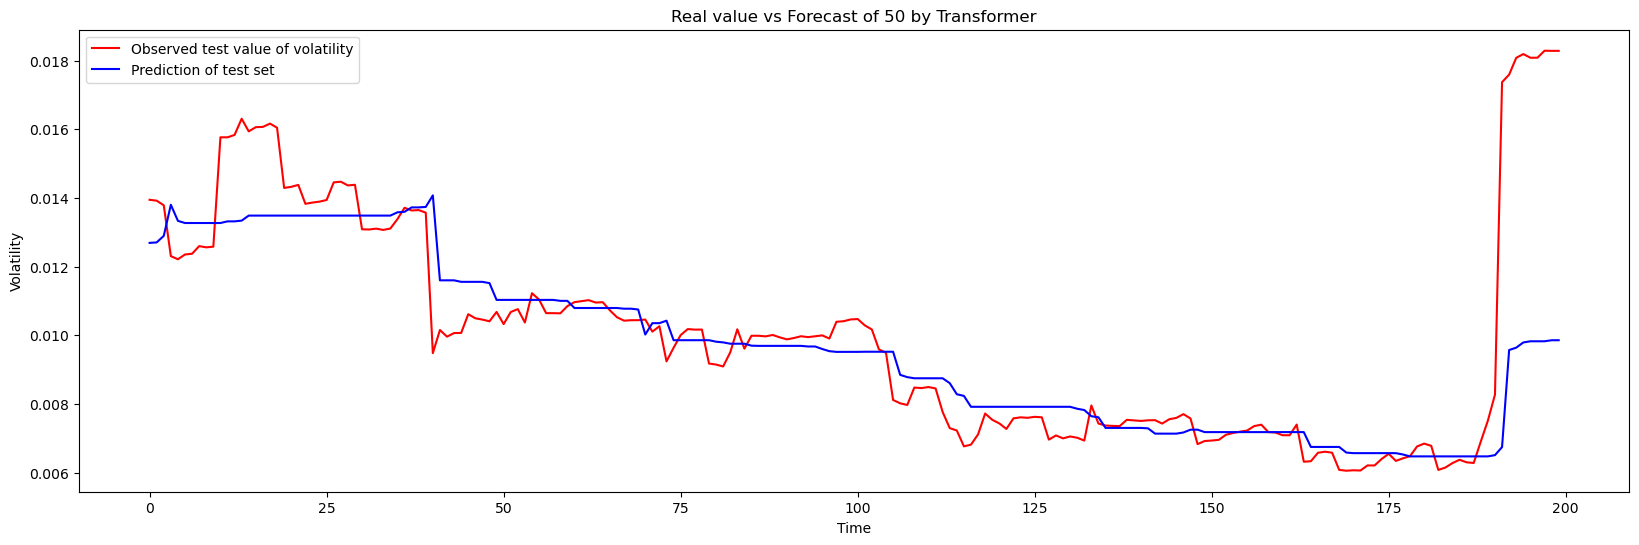

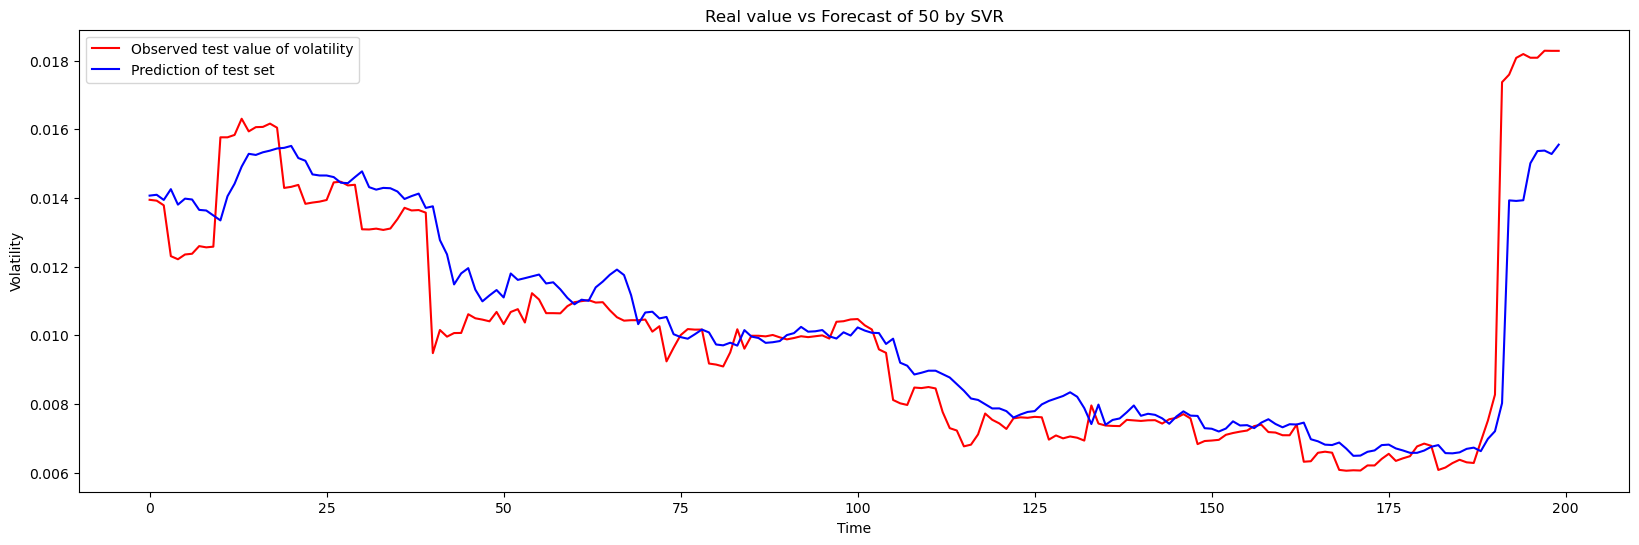

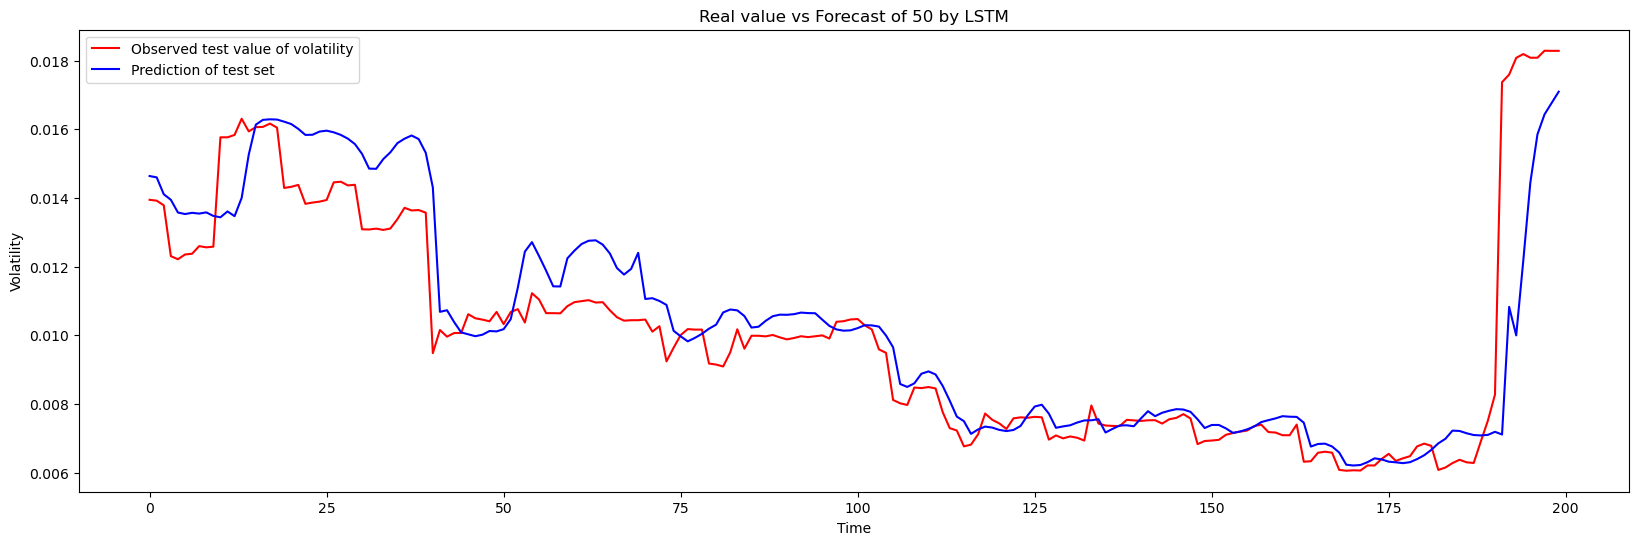

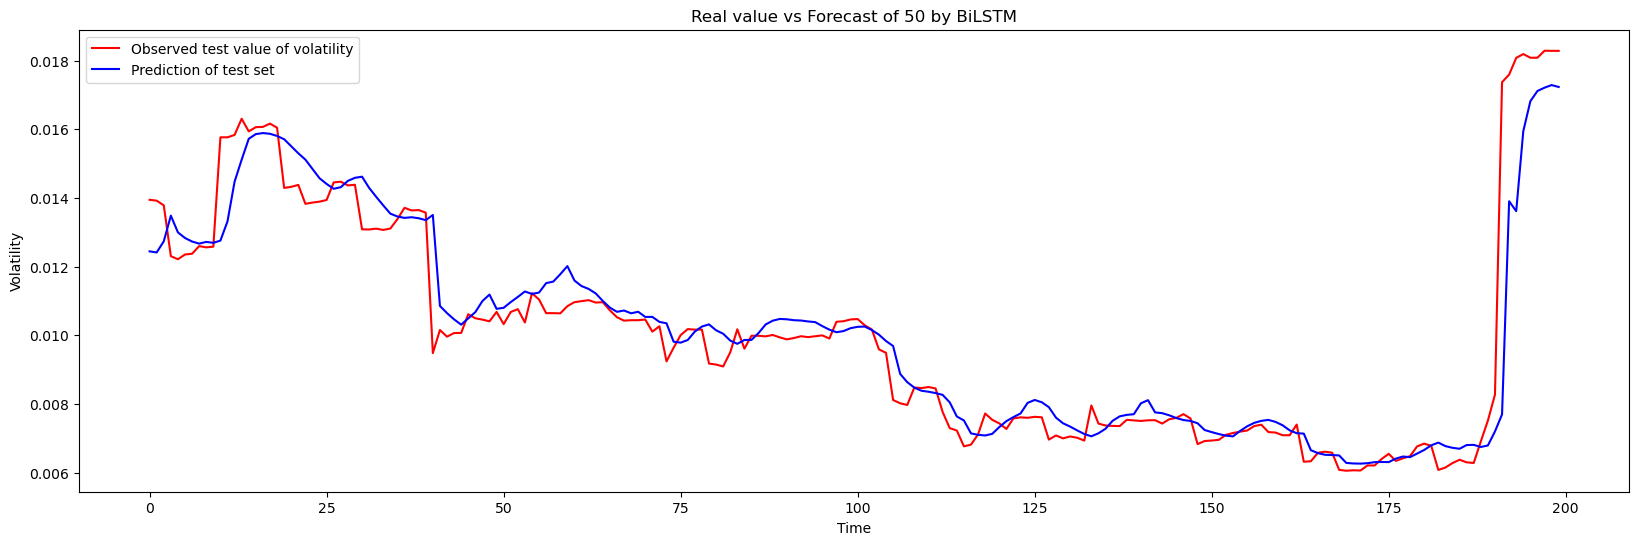

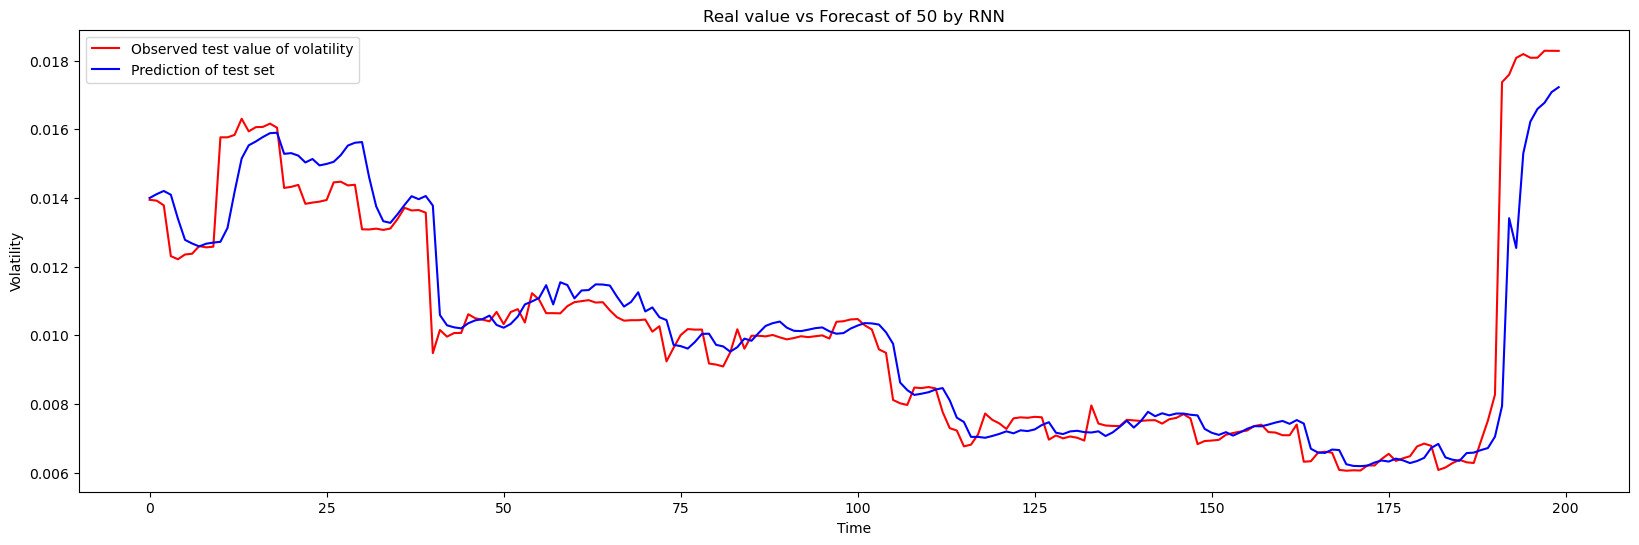

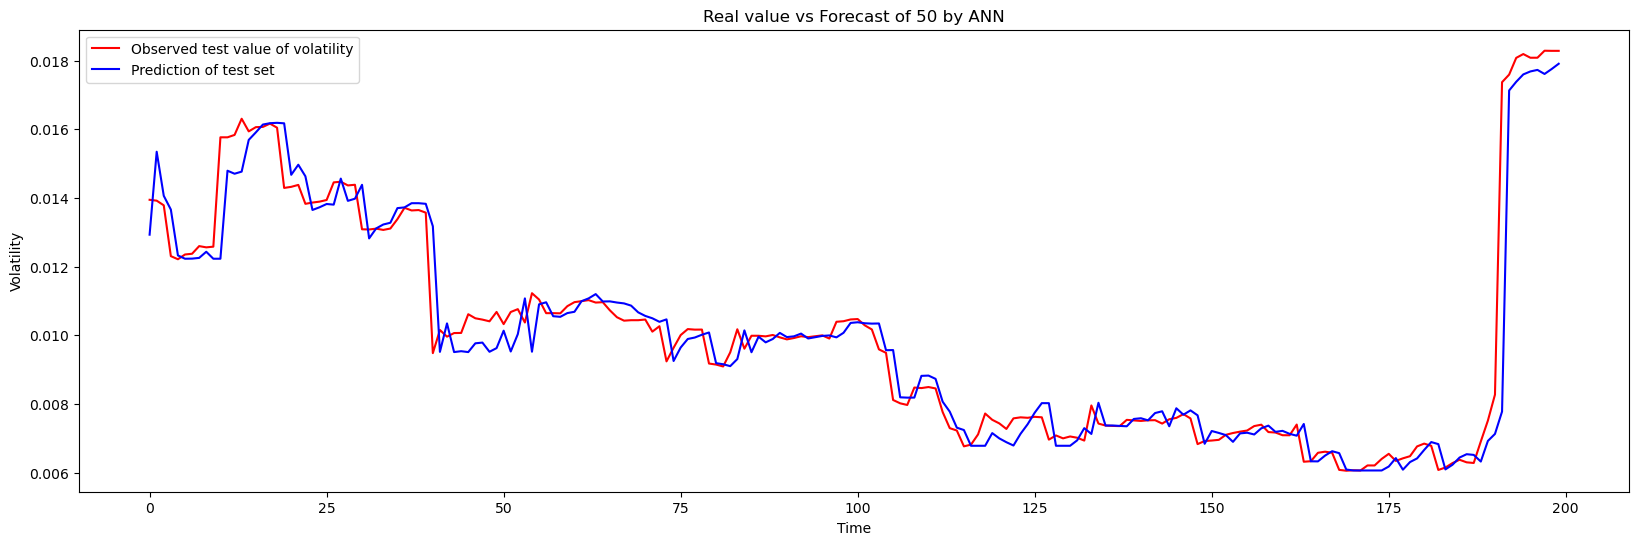

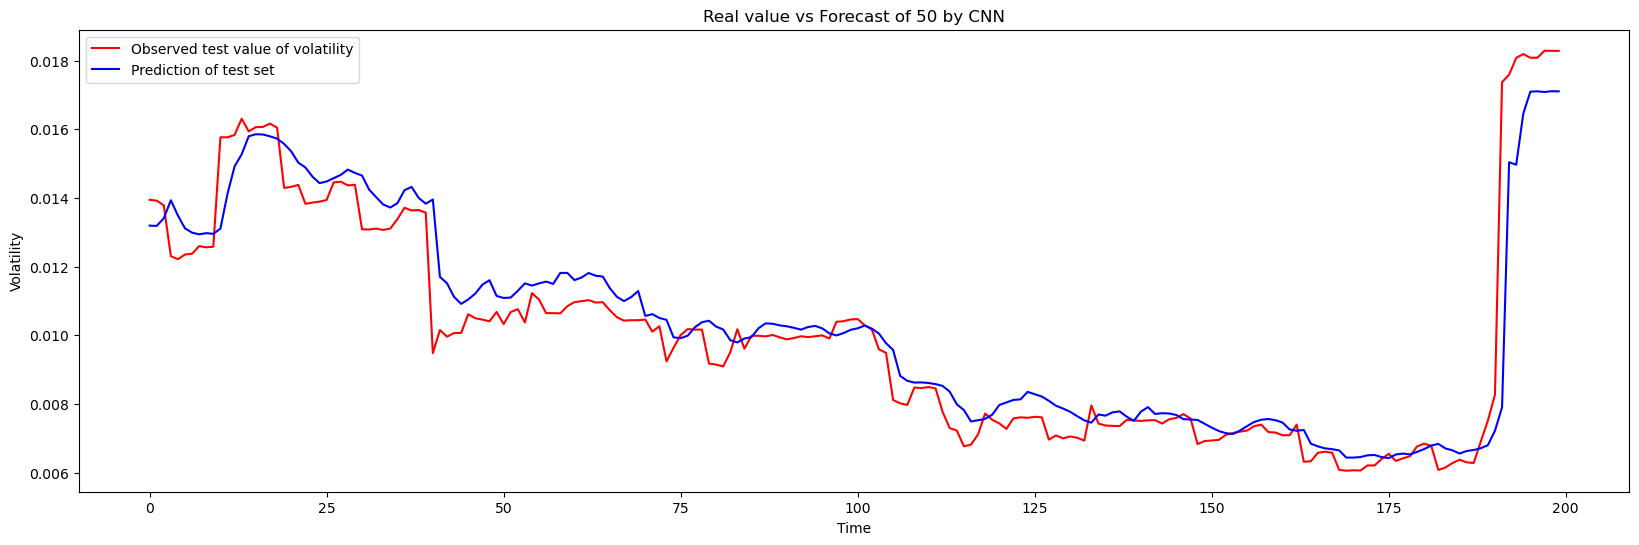

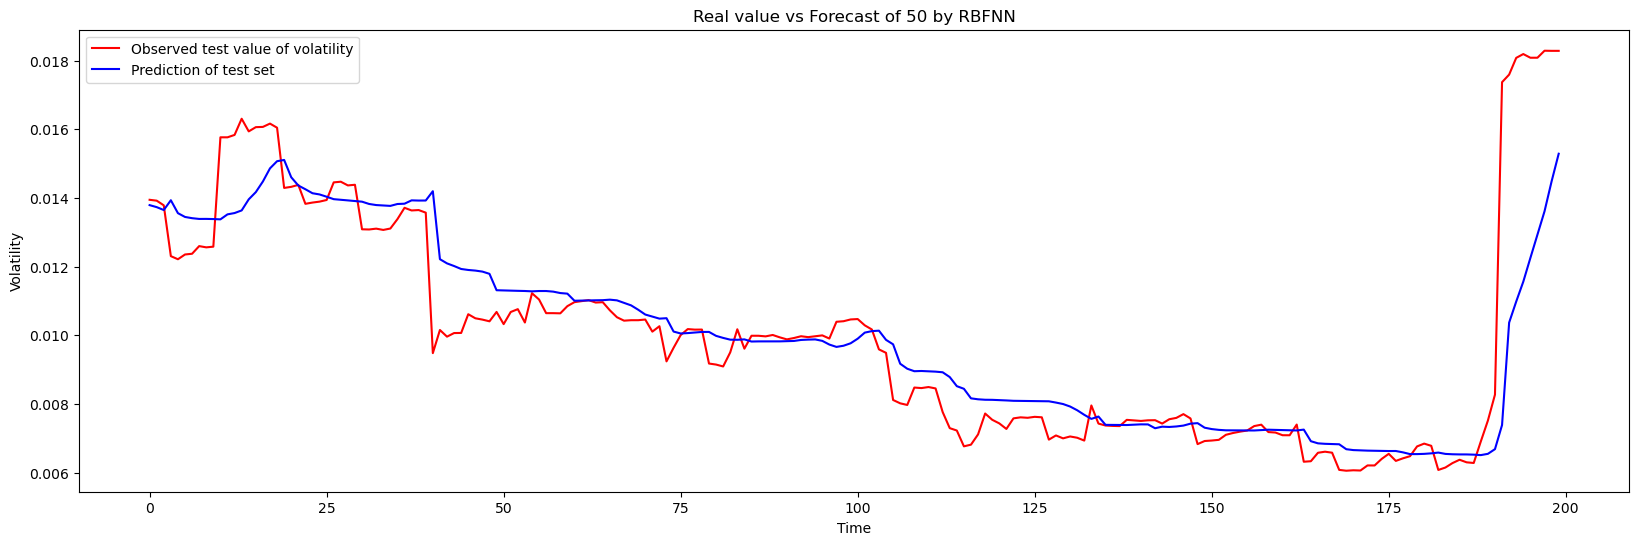

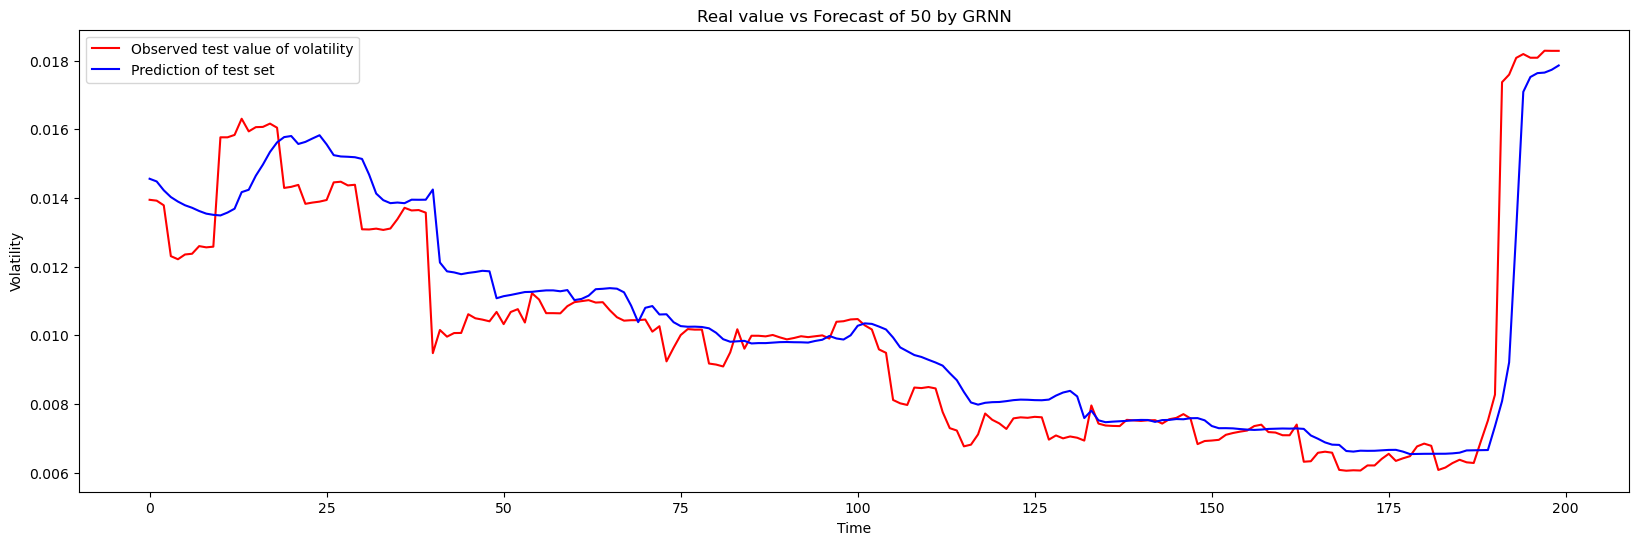

In [38]:
for key in result_dic_key:
    plot_result(name,result_dic[key],btc,key,train1)